In [90]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [91]:
invoice = pd.read_csv('.\Cleaned_Data\cleaned_merged_data.csv')

In [92]:
invoice.shape

(936275, 34)

### Calculating service time in Hrs 

In [93]:
invoice['year'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.year
invoice['month'] = pd.to_datetime(invoice['Invoice_DateTime']).dt.month
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice_DateTime"],dayfirst=True)
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard_DateTime"],dayfirst=True)
invoice['Service_Time'] = invoice['Invoice_DateTime'] - invoice['JobCard_DateTime']
invoice['Service_Time_Hrs'] = invoice['Service_Time']/np.timedelta64(1,'h')
invoice['Service_Time_Hrs'].describe()

count    936275.000000
mean         89.878782
std         275.095915
min          -0.009167
25%           4.048611
50%          23.258889
75%          73.230278
max       17769.261389
Name: Service_Time_Hrs, dtype: float64

In [94]:
invoice[invoice['Service_Time_Hrs']<0]

,Unnamed: 0,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
714423,714423,Retail,182085,00:00:00,7167000988,363294,62001,0.0,MARUTI SUZUKI,0.0,SWIFT DZIRE,0.0,Running Repairs,0.0,603103,X085,X085 - SRI MOTORS,NO,0.0,0.0,X085SA1,2016-05-02 15:12:11,2016-05-02 15:12:44,-1 days +23:59:27,Kanchipuram,Tamil Nadu,"Kelambakkam, Padur, Thaiyur, Pudupakkam",191639,1.0,Z001,363294.0,G2TX,0.0,0.0,2016,5,-0.009167


In [95]:
# dropping a row where service time is in negative
invoice.drop(index=714423,axis=0,inplace=True)

In [96]:
invoice.head()

,Unnamed: 0,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
0,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P001,1203.14,73.0,2015,1,477.014722
1,1,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P002,2348.75,6.5,2015,1,477.014722
2,2,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P010,500.06,1.0,2015,1,477.014722
3,3,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,Thane,Maharashtra,"Kopri Colony, Thane East",89441,1.0,Z001,173997.0,P001,804.26,170.0,2015,1,19.920556
4,4,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,Thane,Maharashtra,"Kopri Colony, Thane East",89441,1.0,Z001,173997.0,P011,197.03,1.0,2015,1,19.920556


### Calculation of Life Time Value for each customer over a period of 2015 (1 year) based on "Make" and "Model" of the cars

In [97]:
invoice_15=invoice[invoice["year"]==2015]

In [98]:
invoice_15.shape

(248353, 37)

In [99]:
invoice_15.head()

,Unnamed: 0,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Labour Total,Make,Misc Total,Model,OSL Total,Order Type,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Total Amt Wtd Tax.,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Business Partner,Partner Type,Data Origin,DBM Order,Item Category,Net value,Order Quantity,year,month,Service_Time_Hrs
0,0,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P001,1203.14,73.0,2015,1,477.014722
1,1,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P002,2348.75,6.5,2015,1,477.014722
2,2,Retail,67849,00:00:00,7005200002,168303,49317,1203.14,GENERAL MOTORS,0.00,SPARK,500.06,Paid Service,2348.75,400601,BC01,THANE,NO,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane H.O, Thane Bazar, Thane R.S.",71941,1.0,Z007,168303.0,P010,500.06,1.0,2015,1,477.014722
3,3,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,Thane,Maharashtra,"Kopri Colony, Thane East",89441,1.0,Z001,173997.0,P001,804.26,170.0,2015,1,19.920556
4,4,Retail,84419,00:00:00,7005200003,173997,78584,804.26,TATA MOTORS,197.03,INDICA,0.00,SMC Value Package,0.00,400603,BC01,THANE,NO,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,Thane,Maharashtra,"Kopri Colony, Thane East",89441,1.0,Z001,173997.0,P011,197.03,1.0,2015,1,19.920556


In [100]:
# Calculating frequency of visits & total revenue of a customer for calculation of ltv

customer_freq=invoice_15.groupby(["Make","Model","Clean_Location_Area","Customer No."]).agg({"Invoice No":'nunique',"Total Amt Wtd Tax.":'mean',"Service_Time_Hrs":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head()

ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r["Invoice No"] * ltv_make_model_r["Total Amt Wtd Tax."]
ltv_make_model_r.head()

,Make,Model,Clean_Location_Area,Customer No.,Invoice No,Total Amt Wtd Tax.,Service_Time_Hrs,LTV
0,AUDI,A4,"Bhatoli, Charatghar, Nangran, Mehatpur (Una), ...",137682,1,359.87,0.052778,359.87
1,AUDI,A4,"Chanod Md, Vapi I.E.",128276,1,2480.49,2.973889,2480.49
2,AUDI,A4,"Deccan Gymkhana, A.R. Shala, Film Institute",98005,1,14549.91,103.956667,14549.91
3,AUDI,A4,Electronics City,113926,1,21834.92,28.306389,21834.92
4,AUDI,A4,"Ferozepur H.O, Sadar Bazar (Firozpur), Cantt R...",89967,2,381.42,1.582685,762.84


### Filtering customer having LTV/Total revenue > 0 

In [104]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [105]:
ltv_make_model_r.shape

(65088, 8)

### Quantile based analysis of LTV to decide threshold

In [106]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 194.9840000000001
0.25 quantile :- 749.4
0.50 quantile :- 3036.01
0.75 quantile :- 8801.681363636362
0.95 quantile :- 33434.124277777766
minimum LTV :- 0.85
maximum LTV :- 2109690.8168778275
mean LTV :- 8739.854409827778


In [107]:
print(ltv_make_model_r[ltv_make_model_r["LTV"]<=3036.01].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV"]>3036.01)&(ltv_make_model_r["LTV"]<=8801.681363636362)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV"]>8801.681363636362].shape)

(32544, 8)
(16272, 8)
(16272, 8)


In [108]:
bins=[-1,3036.01,8801.681363636362,2109690.8168778275]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV"], bins=bins, labels=labels)

In [109]:
ltv_make_model_r["LTV Binned"].value_counts(dropna=False)

Low       32544
High      16272
Medium    16272
Name: LTV Binned, dtype: int64

In [110]:
ltv_make_model_r.dropna(inplace=True)

In [111]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [112]:
le=LabelEncoder()
temp_ltv_make_model_r["Make"]=le.fit_transform(temp_ltv_make_model_r["Make"])
temp_ltv_make_model_r["Model"]=le.fit_transform(temp_ltv_make_model_r["Model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["Clean_Location_Area"]=le.fit_transform(temp_ltv_make_model_r["Clean_Location_Area"])

In [113]:
temp_ltv_make_model_r.head()

,Make,Model,Clean_Location_Area,Customer No.,Invoice No,Total Amt Wtd Tax.,Service_Time_Hrs,LTV,LTV Binned
0,0,7,343,137682,1,359.87,0.052778,359.87,1
1,0,7,445,128276,1,2480.49,2.973889,2480.49,1
2,0,7,576,98005,1,14549.91,103.956667,14549.91,0
3,0,7,673,113926,1,21834.92,28.306389,21834.92,0
4,0,7,711,89967,2,381.42,1.582685,762.84,1


In [114]:
X=temp_ltv_make_model_r.drop(["Customer No.","LTV","LTV Binned","Invoice No"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [115]:
list(X)

['Make',
 'Model',
 'Clean_Location_Area',
 'Total Amt Wtd Tax.',
 'Service_Time_Hrs']

In [116]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

### Decision Tree Classifier

In [121]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78      4855
           1       0.88      0.97      0.93      9781
           2       0.68      0.75      0.72      4891

    accuracy                           0.84     19527
   macro avg       0.84      0.79      0.81     19527
weighted avg       0.85      0.84      0.84     19527



In [129]:
print("Training Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("Testing Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8394530649869412
Testing Accuracy :- 0.8442308114396084


<BarContainer object of 5 artists>

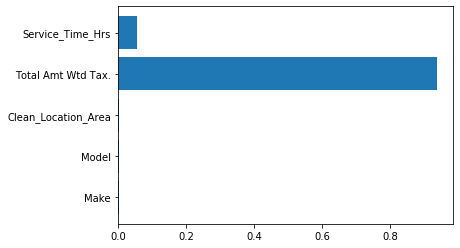

In [128]:
plt.barh(list(X),list(dt.feature_importances_))

In [131]:
### Cross Validation Score

dt_cv_score=cross_val_score(estimator=dt,X=X,y=y,cv=5)

print(dt_cv_score.mean())

0.8313359877913766


### Random Forest Classifier

In [132]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)

In [133]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [134]:
y_pred_rfc=rfc.predict(X_test)

In [135]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      4855
           1       0.86      1.00      0.93      9781
           2       0.73      0.68      0.71      4891

    accuracy                           0.84     19527
   macro avg       0.84      0.79      0.81     19527
weighted avg       0.85      0.84      0.84     19527



In [136]:
accuracy_score(y_test,y_pred_rfc)

0.8445741793414246

<BarContainer object of 5 artists>

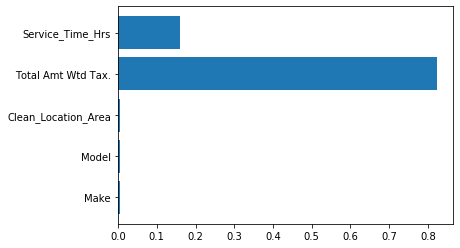

In [137]:
plt.barh(list(X),list(rfc.feature_importances_))

In [138]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [139]:
score.mean()

0.8063384076034774

### XgBoost Classifier

In [140]:
xgb=XGBClassifier()

In [141]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [142]:
y_pred_xgb=xgb.predict(X_test)

In [143]:
accuracy_score(y_test,y_pred_xgb)

0.8468786808009423

In [144]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      4855
           1       0.87      0.99      0.93      9781
           2       0.73      0.70      0.71      4891

    accuracy                           0.85     19527
   macro avg       0.85      0.80      0.81     19527
weighted avg       0.85      0.85      0.84     19527



In [145]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)

In [146]:
scores_xgb.mean()

0.8092263856287865